# GC-MS data analysis 

Analysis of the GC-MS raw data generated on 13.12.2023 (2023 samples) and 31.1.2024 (2021 and 2022 samples).

Environments: 
* `qiime2-2023.2` --> but issues with cartopy (use earlier environment)

In [3]:
import pandas as pd
import numpy as np
import os

# some statistics 
from scipy.stats import zscore
from skbio import DistanceMatrix
from skbio.stats.distance import permanova, anosim
from itertools import product
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier

# Import from PubChem 
#import requests 
#import pubchempy as pcp

# qiime 2 
import qiime2 as q2
from qiime2 import Visualization
from qiime2 import Artifact, Metadata
#from qiime2.plugins.diversity.visualizers import mantel

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

%matplotlib inline

# Load raw data 

* Of each sample we have 3 measurements, we import all raw data and get the average over each sample.
* Some compounds were annotated twice, so we just add the values to each other (sometimes a compound is integrated as multiple peaks)
* Further we rename the columns to make analysis easier. 

In [4]:
# set the directory 
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Metabolomics/GC-MS')

### 2021 / 2022 data

In [5]:
# load table 
df_2021_2022 = pd.read_csv('rawGCMS_results_2021_2022.csv', index_col=0)
# replace "n.a." to represent scalar missing values
df_2021_2022.replace('n.a.', pd.NA, inplace=True)
# drop CAS column for now 
df_2021_2022.drop(columns=['CAS'], inplace=True)

# first split the dataframes based on the years 
year_2021_columns = [col for col in df_2021_2022.columns if '2021' in col]
year_2022_columns = [col for col in df_2021_2022.columns if '2022' in col]

# Create new DataFrames for each year
df_2021 = df_2021_2022[year_2021_columns].copy()
df_2022 = df_2021_2022[year_2022_columns].copy()

# Extract the last section of each column name
grouped_columns = df_2022.columns.str.rsplit('_', n=1).str[-1]
# Group the DataFrame by the extracted section and calculate the median for each group
df_2022_median = df_2022.groupby(grouped_columns, axis=1).median().groupby(df_2022.index).sum()
# add back the info to the columns 
df_2022_median = df_2022_median.add_prefix('2022_postMLF_')

# Extract the last section of each column name
grouped_columns = df_2021.columns.str.rsplit('_', n=1).str[-1]
# Group the DataFrame by the extracted section and calculate the median for each group
df_2021_median = df_2021.groupby(grouped_columns, axis=1).median().groupby(df_2021.index).sum()
# add back the info to the columns 
df_2021_median = df_2021_median.add_prefix('2021_postMLF_')

/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/lfl

#### Save the 2022 data for a comparison with the Sensory Data 

In [6]:
### TSN normalization
sum_per_profile = df_2022_median.sum(axis=0)
df_2022_median_normalized = df_2022_median.div(sum_per_profile, axis=1)

# transpose and rename 
df_2022_median_T = df_2022_median_normalized.transpose().reset_index(names=['Name'])
df_2022_median_T['Name'] = df_2022_median_T['Name'].apply(lambda x: x.replace('_postMLF', ''))

df_2022_median_T.to_csv('GC-2022-forCorrelation.csv')

### 2023 data

In [7]:
# load table 
df_2023 = pd.read_csv('rawGCMS_results_2023.csv', index_col=0)
# replace "n.a." to represent scalar missing values 
df_2023.replace('n.a.', pd.NA, inplace=True)

# split the dataframes based on sample type 
postMLF_columns = [col for col in df_2023.columns if 'PostMLF' in col]
postAF_columns = [col for col in df_2023.columns if 'PostAF' in col]
must_columns = [col for col in df_2023.columns if 'Must' in col]

# Create new DataFrames for each type
df_2023_postMLF = df_2023[postMLF_columns].copy()
df_2023_postAF = df_2023[postAF_columns].copy()
df_2023_must = df_2023[must_columns].copy()

# Extract the last section of each column name
grouped_columns = df_2023_must.columns.str.rsplit('_', n=1).str[-1]
# Group the DataFrame by the extracted section and calculate the median for each group
df_2023_must_median = df_2023_must.groupby(grouped_columns, axis=1).median().groupby(df_2023_must.index).sum()
# add back the info to the columns 
df_2023_must_median = df_2023_must_median.add_prefix('2023_must_')

grouped_columns = df_2023_postAF.columns.str.rsplit('_', n=1).str[-1]
df_2023_postAF_median = df_2023_postAF.groupby(grouped_columns, axis=1).median().groupby(df_2023_postAF.index).sum()
df_2023_postAF_median = df_2023_postAF_median.add_prefix('2023_postAF_')

grouped_columns = df_2023_postMLF.columns.str.rsplit('_', n=1).str[-1]
df_2023_postMLF_median = df_2023_postMLF.groupby(grouped_columns, axis=1).median().groupby(df_2023_postMLF.index).sum()
df_2023_postMLF_median = df_2023_postMLF_median.add_prefix('2023_postMLF_')


/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/lfl

### Metadata on the plots

In [8]:
plots_md = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Lavaux_plots_md.csv', index_col=0)
plots_md.head()

,Altitude,Average_slope,Exposition,Min_radiation,Max_radiation,Average_radiation,Soil_thickness,Soil_type,Soil_depth,Hydromorphie,Hydromorphie_code,Geology,Coordinates,Longitude,Latitude
Plot,,,,,,,,,,,,,,,
4,450,30,South-West,925,950,937.5,calcosol,Calcaire,100-180,Slightly_redox,1,Molasse,46°29′55.815″N 6°42′29.007″E,46.498857,6.708072
5,400,30,South-West,900,925,912.5,calcosol,Calcaire,100-180,no_redox,0,Molasse,46°29′47.037″N 6°42′31.353″E,46.496407,6.708712
9,520,35,South-West,875,900,887.5,calcosol,Calcaire,100-180,no_redox,0,Molasse,46°29′57.936″N 6°42′44.103″E,46.499468,6.712242
11,490,20,South,925,950,937.5,calcosol,Calcaire,100-180,Slightly_redox,1,Gravel_moraine,46°30′00.818″N 6°42′23.968″E,46.500244,6.706655
12,520,15,South-West,925,950,937.5,colluviosol,Calcique,above_150,Slightly_redox,1,Colluvium,46°30′09.426″N 6°42′17.825″E,46.502628,6.704952


## Merge and Normalize 
Normalization according to Total Sum Normalization (TSN)

> TSN is the simplest method for normalizing GC-MS data. It requires dividing the area of each peak in a profile by the total sum of all peaks within that profile such that for the ith peak (xi) of jth profile. (Ref. https://doi.org/10.1002/bies.201700210)


--> apply to the different dataframes we are working with


In [9]:
# MLF data
combined_df_MLF = pd.concat([df_2021_median, df_2022_median, df_2023_postMLF_median], axis=1).dropna(how='all')
# Rename columns by removing "postMLF_" from the names
combined_df_MLF.columns = [col.replace("postMLF_", "") for col in combined_df_MLF.columns]

### TSN normalization
sum_per_profile = combined_df_MLF.sum(axis=0)
# Apply Total Sum Normalization by dividing each value by the sum of its corresponding column
combined_MLF_normalized = combined_df_MLF.div(sum_per_profile, axis=1)

In [10]:
combined_MLF_normalized.head()

,2021_Plot11,2021_Plot12,2021_Plot13,2021_Plot14,2021_Plot15,2021_Plot17,2021_Plot18,2021_Plot19,2021_Plot20,2021_Plot4,...,2023_Plot12,2023_Plot13,2023_Plot14,2023_Plot15,2023_Plot17,2023_Plot19,2023_Plot20,2023_Plot4,2023_Plot5,2023_Plot9
Name,,,,,,,,,,,,,,,,,,,,,
Nonanoic acid,0.01397,0.034076,0.003409,0.116630,0.078968,0.057038,0.105728,0.048042,0.084714,0.013101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(5Z)-Octa-1,5-dien-3-ol",0.00000,0.000000,0.000000,0.002705,0.002638,0.002611,0.001540,0.000000,0.000000,0.000444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(S)-(+)-6-Methyl-1-octanol,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"1,2-Benzenedicarboxylic acid, bis(2-methylpropyl) ester",0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"1,3-Propanediol, diacetate",0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# 2023 data
combined_df_2023 = pd.concat([df_2023_must_median, df_2023_postAF_median, df_2023_postMLF_median], axis=1).dropna(how='all')
combined_df_2023.columns = [col.replace("2023_", "") for col in combined_df_2023.columns]

### TSN normalization
sum_per_profile = combined_df_2023.sum(axis=0)
# Apply Total Sum Normalization by dividing each value by the sum of its corresponding column
combined_2023_normalized = combined_df_2023.div(sum_per_profile, axis=1)

In [12]:
# ALL data
all_combined_df = pd.concat([df_2023_must_median, df_2023_postAF_median, df_2021_median, df_2022_median, df_2023_postMLF_median], axis=1).dropna(how='all')

### TSN normalization
sum_per_profile = all_combined_df.sum(axis=0)
# Apply Total Sum Normalization by dividing each value by the sum of its corresponding column
all_combined_df_normalized = all_combined_df.div(sum_per_profile, axis=1)

# Compare the MLF sample from different years

### Heatmap MLF samples 

#### Normalized

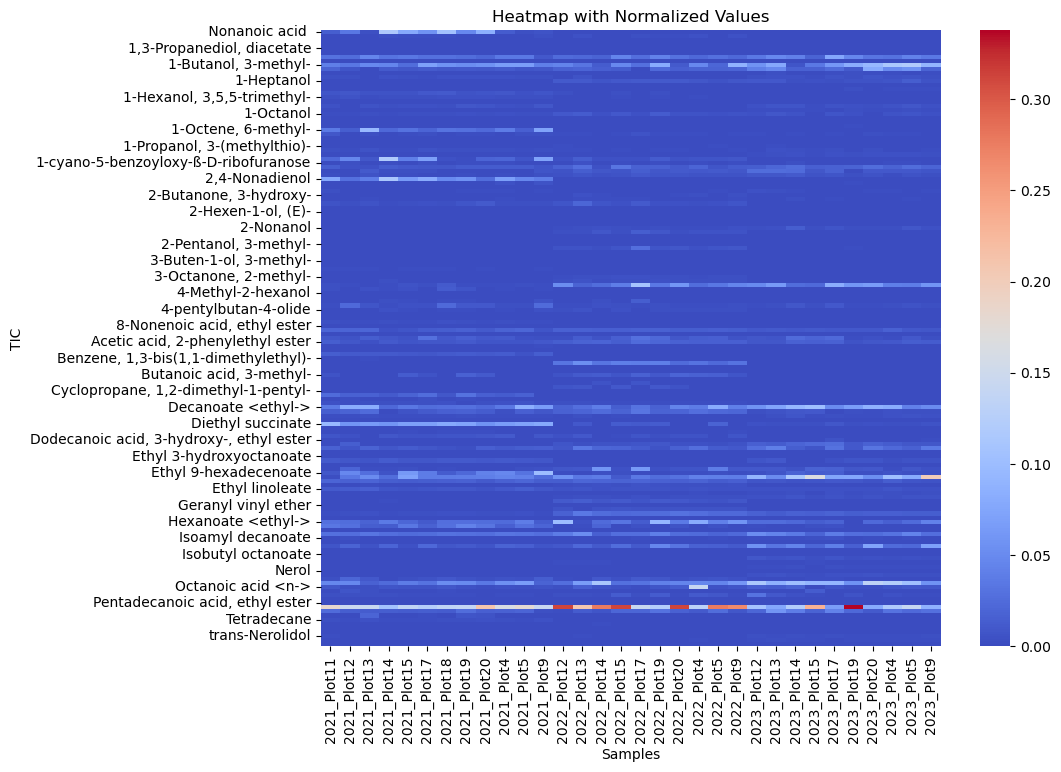

In [13]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(combined_MLF_normalized, cmap='coolwarm', annot=False)
plt.title('Heatmap with Normalized Values')
plt.xlabel('Samples')
plt.ylabel('TIC')
plt.show()

#### Z score

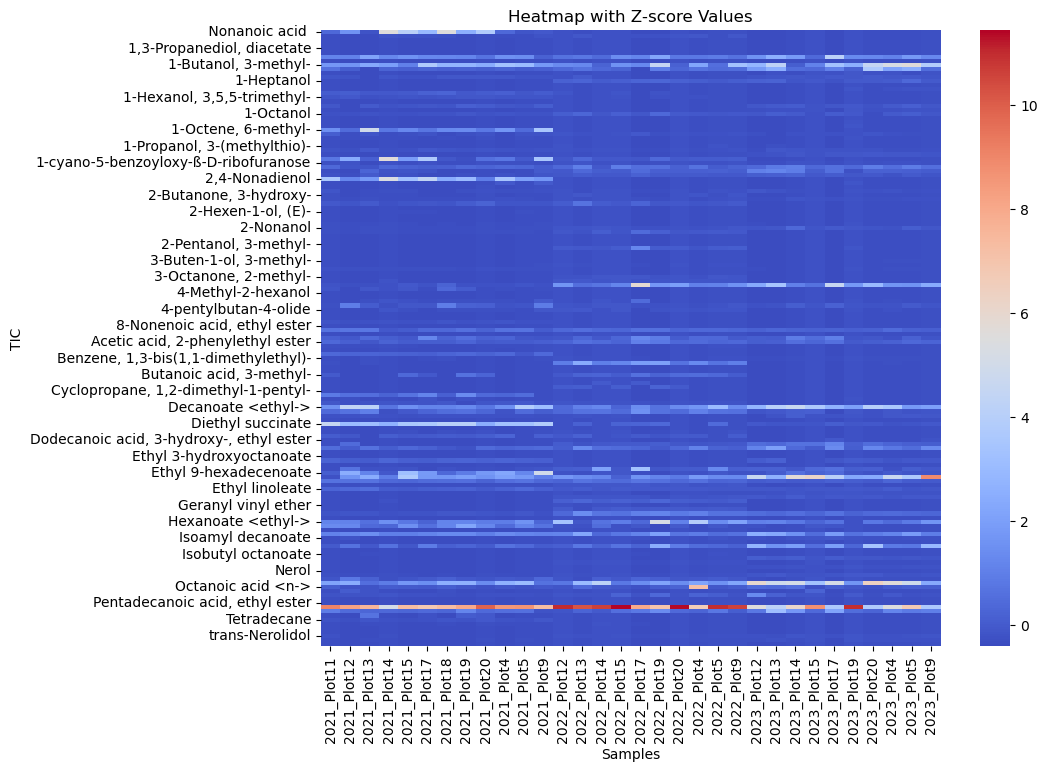

In [14]:
# Calculate z-scores for the DataFrame
z_scores_MLF = (combined_MLF_normalized - combined_MLF_normalized.mean()) / combined_MLF_normalized.std()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(z_scores_MLF, cmap='coolwarm', annot=False)
plt.title('Heatmap with Z-score Values')
plt.xlabel('Samples')
plt.ylabel('TIC')
plt.show()

<Figure size 1500x800 with 0 Axes>

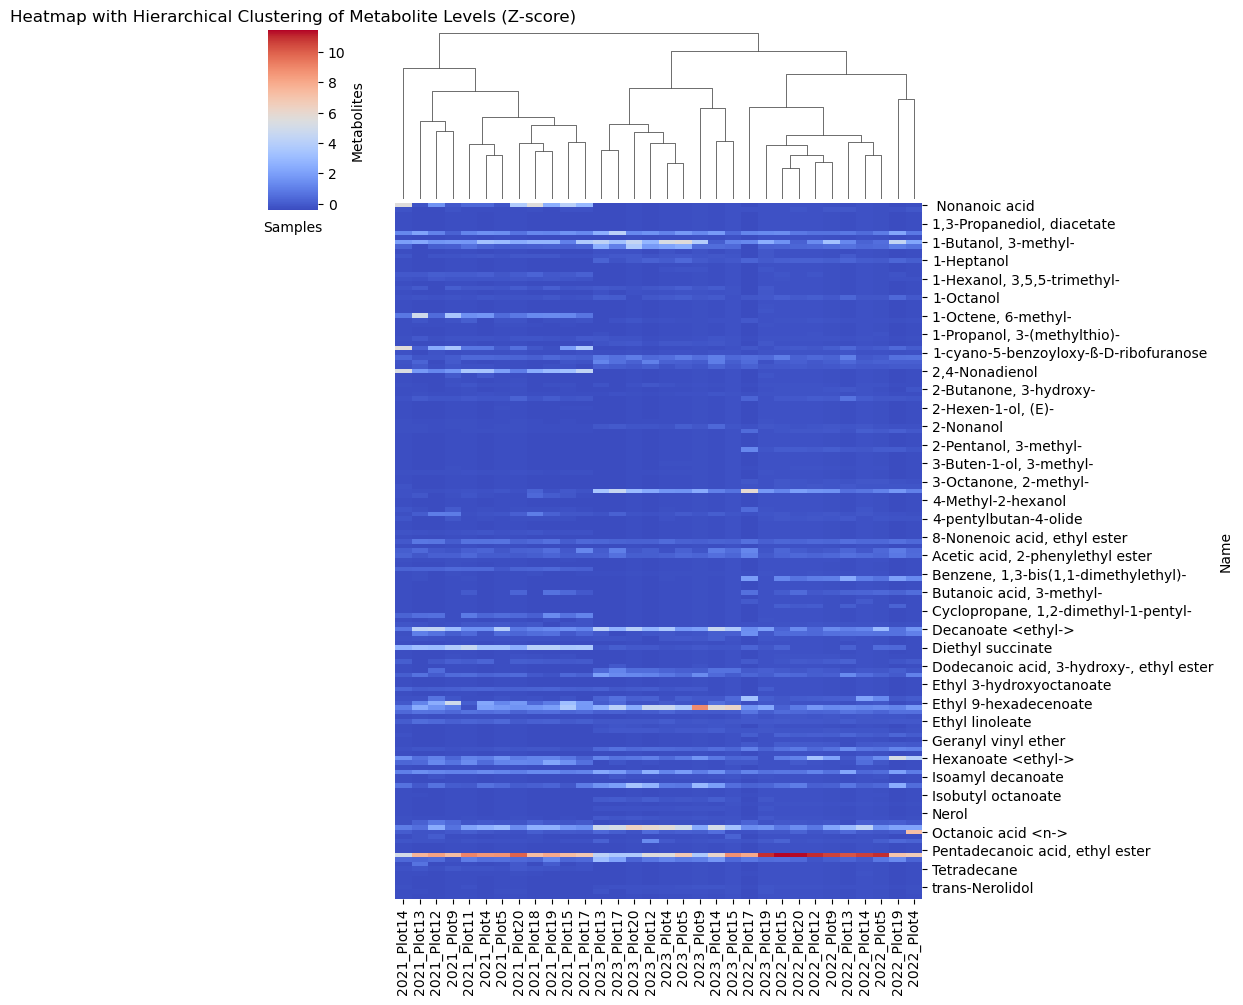

In [15]:
# Perform hierarchical clustering on the metabolite levels
linkage = hierarchy.linkage(z_scores_MLF.T, method='complete', metric='euclidean')

# Plot the heatmap with hierarchical clustering
plt.figure(figsize=(15, 8))
sns.clustermap(z_scores_MLF, method='complete', metric='euclidean', cmap='coolwarm', col_linkage=linkage, row_cluster=False)
plt.title('Heatmap with Hierarchical Clustering of Metabolite Levels (Z-score)')
plt.xlabel('Samples')
plt.ylabel('Metabolites')
plt.show()

#### Heatmap Top variable compounds

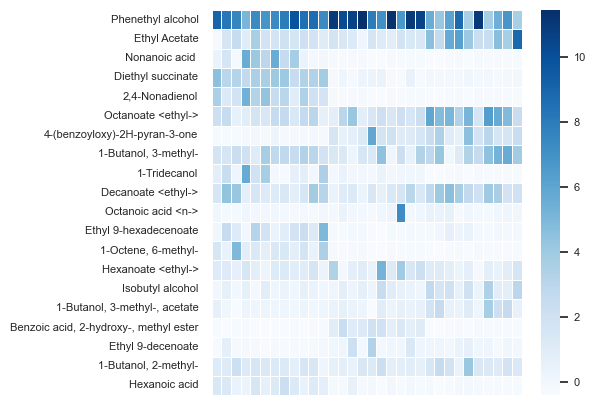

In [16]:
# Get the top 10 variable compounds based on their standard deviation
top_20_compounds = z_scores_MLF.std(axis=1).nlargest(20).index
# Select only the top 10 variable compounds
top_20_compounds_df = z_scores_MLF.loc[top_20_compounds]

# Create a heatmap
plt.figure(figsize=(5, 5))
sns.set(rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8})
ax = sns.heatmap(top_20_compounds_df, annot=False, cmap='Blues', cbar=True, linewidths=.5, xticklabels=False)
ax.set(ylabel=None)
#plt.title('Compounds with largest variation between postMLF samples of different years [TIC]')

plt.savefig('Figures/postMLF-Top20var.png', bbox_inches='tight', dpi=1000) 
plt.show()

<Figure size 200x300 with 0 Axes>

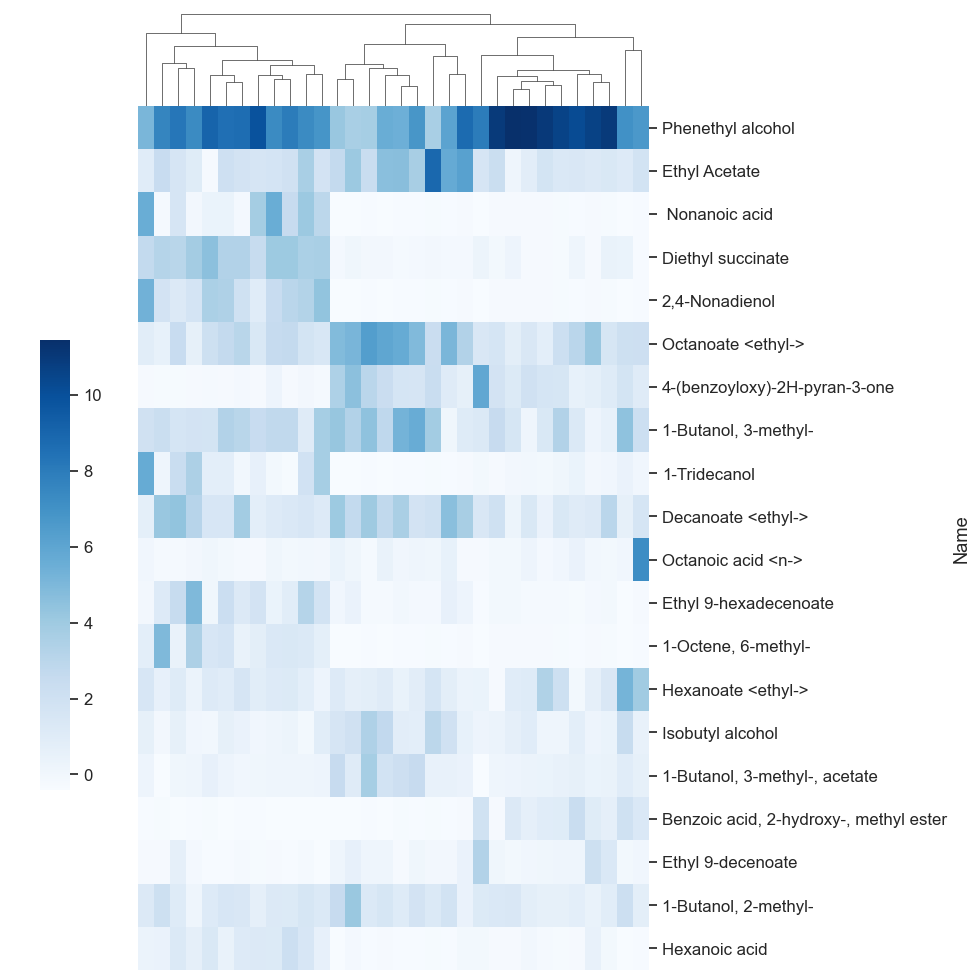

In [17]:
# Perform hierarchical clustering on the metabolite levels
#linkage = hierarchy.linkage(z_scores_MLF.T, method='complete', metric='euclidean')

# Get the top 10 variable compounds based on their standard deviation
top_20_compounds = z_scores_MLF.std(axis=1).nlargest(20).index
# Select only the top 10 variable compounds
top_20_compounds_df = z_scores_MLF.loc[top_20_compounds]

sns.set(font_scale=1.1)
# Create a heatmap
plt.figure(figsize=(2, 3))
cluster = sns.clustermap(top_20_compounds_df, method='complete', metric='euclidean', 
                    cmap='Blues', col_linkage=linkage, row_cluster=False, xticklabels=False, dendrogram_ratio=(.2, .1))
cluster.cax.set_position([.05, .2, .03, .45])
#ax.set(ylabel=None)
plt.yticks(fontsize=12)  # Increase y-axis tick fontsize
plt.xticks([])  # Remove x-axis ticks
plt.gca().set_ylabel('')  # Remove y-axis name
plt.gca().set_xlabel('')  # Remove y-axis name
#plt.title('Compounds with largest variation between postMLF samples of different years [TIC]')

plt.savefig('Figures/postMLF-Top20var-cluster.png', bbox_inches='tight', dpi=1000) 
plt.show()

<Figure size 200x500 with 0 Axes>

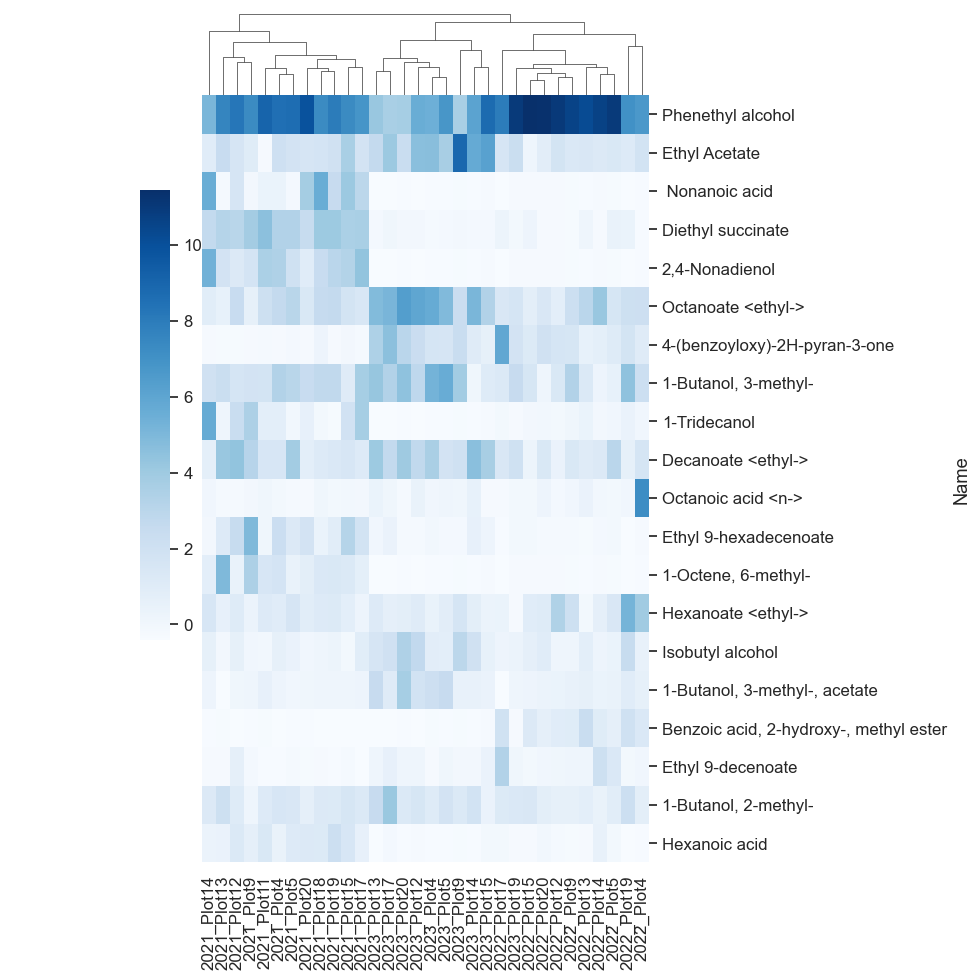

In [18]:
# Perform hierarchical clustering on the metabolite levels
#linkage = hierarchy.linkage(z_scores_MLF.T, method='complete', metric='euclidean')

# Get the top 10 variable compounds based on their standard deviation
top_20_compounds = z_scores_MLF.std(axis=1).nlargest(20).index
# Select only the top 10 variable compounds
top_20_compounds_df = z_scores_MLF.loc[top_20_compounds]

# Create a heatmap
plt.figure(figsize=(2, 5))
cluster = sns.clustermap(top_20_compounds_df, method='complete', metric='euclidean', 
                    cmap='Blues', col_linkage=linkage, row_cluster=False, xticklabels=True, dendrogram_ratio=(.3, .1))
cluster.cax.set_position([.15, .35, .03, .45])
#ax.set(ylabel=None)
plt.xticks([])  # Remove x-axis ticks
plt.gca().set_ylabel('')  # Remove y-axis name
#plt.title('Compounds with largest variation between postMLF samples of different years [TIC]')

#plt.savefig('Figures/postMLF-Top20var-cluster.png', bbox_inches='tight', dpi=1000) 
plt.show()

### PCA Plot of MLF samples 

In [19]:
### Some data prep: 

# drop all rows that contain a NaN because PCA can't handle that 
combined_df_MLF_noNA = combined_MLF_normalized.dropna()

# transpose!
combined_df_MLF_noNA = combined_df_MLF_noNA.transpose()

# add a column that indicates the sample type 
combined_df_MLF_noNA['Year'] = combined_df_MLF_noNA.index.str.split('_').str[0]

# give index a name 
combined_df_MLF_noNA.rename_axis(index='Sample', inplace=True)

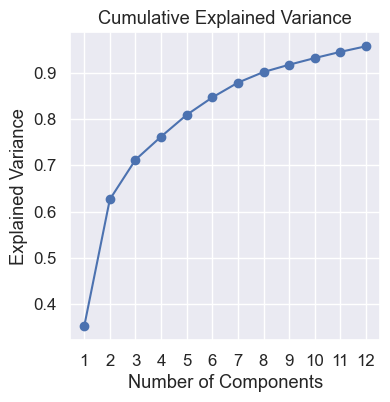

In [20]:
# Instantiate PCA with the max number of components to test --> 12? 
n_components = 12 
pca = PCA(n_components=n_components)

# Fit the PCA to your data
pca.fit(combined_df_MLF_noNA.iloc[:, :-1])

# Plot the explained variance ratio
plt.figure(figsize=(4, 4))
plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.xticks(range(1, n_components + 1))
plt.grid(True)
plt.show()

Not sure what number of components to use! --> let's try some different ones! 

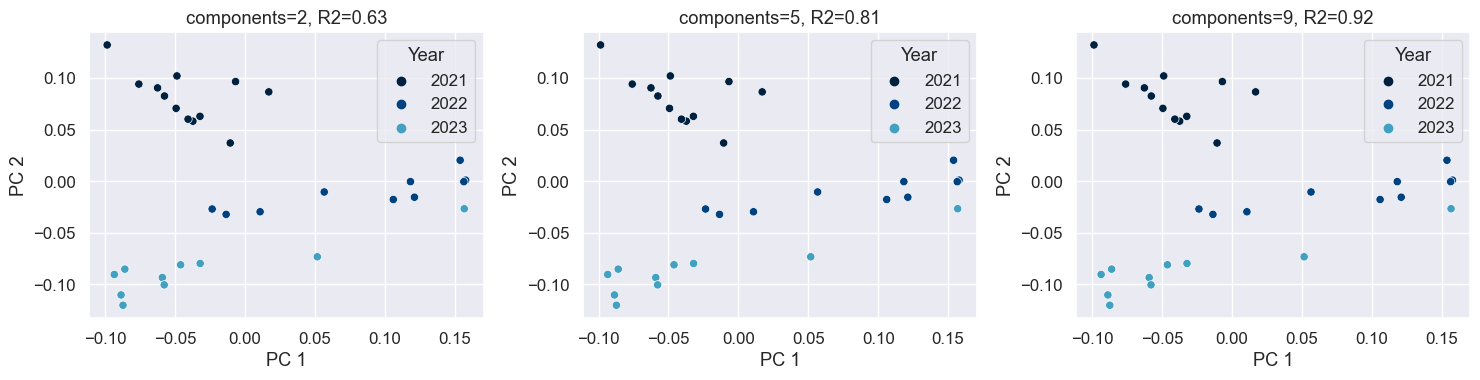

In [21]:
# Define the number of components for each plot
n_components_list = [2, 5, 9]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # Adjust the figsize as needed

# Iterate over each number of components
for i, n_components in enumerate(n_components_list):
    # Instantiate PCA
    pca = PCA(n_components=n_components)
    
    # Fit and transform the data
    pca_result = pca.fit_transform(combined_df_MLF_noNA.iloc[:, :-1])
    
    # Create a DataFrame with the principal components
    pca_columns = [f'PC{i}' for i in range(1, n_components + 1)]
    pca_MLF = pd.DataFrame(data=pca_result, columns=pca_columns, index=combined_df_MLF_noNA.index)
    
    # Add the sample type info back
    pca_MLF['Year'] = combined_df_MLF_noNA['Year']
    
    # Compute R^2 of explained variance
    r2 = pca.explained_variance_ratio_.sum()
    
    # Plot the PCA results with observation labels
    sns.scatterplot(data=pca_MLF, x='PC1', y='PC2', hue='Year', palette='ocean', ax=axes[i])
    axes[i].set_xlabel('PC 1')
    axes[i].set_ylabel('PC 2')
    axes[i].set_title(f'components={n_components}, R2={r2:.2f}')

# Adjust layout
plt.tight_layout()
plt.show()


--> Does not seem to make much difference! Let's proceed with 5

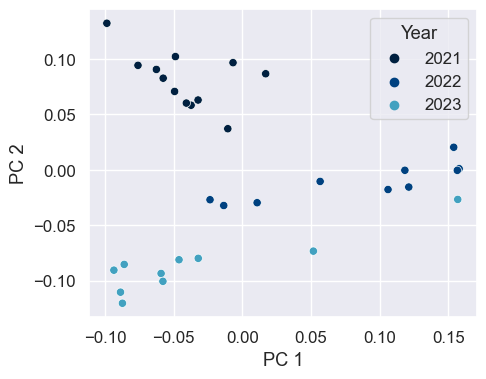

In [22]:
# Instantiate PCA with the number of components you want
n_components = 5  # You can choose the number of principal components
pca = PCA(n_components=n_components)

# Fit and transform the data
pca_result = pca.fit_transform(combined_df_MLF_noNA.iloc[:, :-1])

# Create a DataFrame with the principal components
pca_columns = [f'PC{i}' for i in range(1, n_components + 1)]
pca_MLF = pd.DataFrame(data=pca_result, columns=pca_columns, index=combined_df_MLF_noNA.index)

# add the sample type info back 
pca_MLF['Year'] = combined_df_MLF_noNA['Year']

# Plot the PCA results with observation labels
plt.figure(figsize=(5, 4))

# make scatterplot and color by sample type 
sns.scatterplot(data=pca_MLF, x='PC1', y='PC2', hue='Year', palette='ocean')


#plt.title('PCA Plot of MLF samples')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
#plt.savefig('Figures/PCA-MPF.png', bbox_inches='tight', dpi=1000)
plt.show()

## MLF and plot metadata 


In [6]:
plots_md = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Lavaux_plots_md.csv', index_col=0)

In [7]:
## Modify the metadata to fit the distance matrix 

# Extract the original index (plot numbers)
plot_numbers = plots_md.index
# Initialize an empty list to store duplicated rows
duplicated_rows = []
for plot_number in plot_numbers:
    original_row = plots_md.loc[plot_number]  # Extract the original row
    # Duplicate the row for each year and rename the index accordingly
    for year in [2021, 2022, 2023]:
        new_index = f'{year}_Plot{plot_number}'  # Create the new index name
        duplicated_row = original_row.copy()  # Make a copy of the original row
        duplicated_row.name = new_index  # Rename the index of the copied row
        duplicated_row['Plot'] =  f'Plot{plot_number}'  
        duplicated_row['Year'] = year  # Add a column indicating the year
        duplicated_rows.append(duplicated_row)  # Append the duplicated row to the list
# Concatenate the duplicated rows into a new dataframe
plots_md_duplicated = pd.concat(duplicated_rows, axis=1).T

In [8]:
# Calculate the Bray-Curtis dissimilarity matrix
distance_matrix = pairwise_distances(combined_MLF_normalized.T, metric='braycurtis')
# Convert the distance matrix to a scikit-bio DistanceMatrix object
BC_distance_matrix = DistanceMatrix(distance_matrix, ids=combined_MLF_normalized.columns)

BC_distance_matrix

NameError: name 'combined_MLF_normalized' is not defined

In [9]:
# Convert the DataFrame to a numpy array
data_array = combined_MLF_normalized.T.to_numpy()
# Calculate the Jaccard dissimilarity matrix
distance_matrix = pairwise_distances(data_array, metric='jaccard')
# Convert the distance matrix to a scikit-bio DistanceMatrix object
jaccard_distance_matrix = DistanceMatrix(distance_matrix, ids=combined_MLF_normalized.columns)
jaccard_distance_matrix

NameError: name 'combined_MLF_normalized' is not defined

Only the Year has a significant effect for BC and Jaccard Distance Matrix! 

In [27]:
for column in plots_md_duplicated.columns:
    result = permanova(BC_distance_matrix, grouping=plots_md_duplicated, column=str(column), permutations=99)
    print(f"PERMANOVA Results for {column}:")
    print(result)
    print()  # Add a blank line for better readability between results

PERMANOVA Results for Altitude:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      32
number of groups                  9
test statistic             0.395665
p-value                         1.0
number of permutations           99
Name: PERMANOVA results, dtype: object

PERMANOVA Results for Average_slope:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      32
number of groups                  6
test statistic             0.309335
p-value                         1.0
number of permutations           99
Name: PERMANOVA results, dtype: object

PERMANOVA Results for Exposition:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      32
number of groups                  2
test statistic             0.346475
p-value                        0.95
number of permutations           99
Name: PERMANOVA results, dtype: object

PERMANOVA Results for

In [28]:
for column in plots_md_duplicated.columns:
    result = permanova(jaccard_distance_matrix, grouping=plots_md_duplicated, column=str(column), permutations=99)
    print(f"PERMANOVA Results for {column}:")
    print(result)
    print()  # Add a blank line for better readability between results

PERMANOVA Results for Altitude:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      32
number of groups                  9
test statistic             0.250865
p-value                         1.0
number of permutations           99
Name: PERMANOVA results, dtype: object

PERMANOVA Results for Average_slope:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      32
number of groups                  6
test statistic             0.182292
p-value                         1.0
number of permutations           99
Name: PERMANOVA results, dtype: object

PERMANOVA Results for Exposition:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      32
number of groups                  2
test statistic             0.007126
p-value                         1.0
number of permutations           99
Name: PERMANOVA results, dtype: object

PERMANOVA Results for

### Spatial differences between GC-MS datasets 

1. geodisic distance matrix from the metadata
2. matel with distance matrices 

--> neither jaccard nor BS have a sign. (p<0.05) effect of the distance between plots and VOCs. 

In [29]:
# saving as tsv file and give the index a name to import it as qiime metadata
plots_md_duplicated.rename_axis(index='id').to_csv('plots_metadata.tsv', sep="\t")

Note, the geodisic distance matrix was created in the terminal with `qiime2-2021.2`

`qiime coordinates geodesic-distance 
    --m-metadata-file plots_metadata.tsv 
    --p-latitude Latitude 
    --p-longitude Longitude 
    --p-missing-data ignore 
    --o-distance-matrix geodesic_distance_matrix_sample.qza 
    --verbose `

In [5]:
# load artifacts
jaccard_q2_distance_matrix = Artifact.import_data("DistanceMatrix", jaccard_distance_matrix)
bray_curtis_q2_distance_matrix = Artifact.import_data("DistanceMatrix", BC_distance_matrix)

geodisic_distance_matrix = Artifact.load('geodesic_distance_matrix_sample.qza')

NameError: name 'jaccard_distance_matrix' is not defined

In [222]:
# Mantel tests
mantel_res, = mantel(dm1=jaccard_q2_distance_matrix, dm2=geodisic_distance_matrix, intersect_ids=True)
mantel_res.save('Mantel_Jaccard_Geodesic.qzv')

mantel_res, = mantel(dm1=bray_curtis_q2_distance_matrix, dm2=geodisic_distance_matrix, intersect_ids=True)
mantel_res.save('Mantel_BC_Geodesic.qzv')

'Mantel_BC_Geodesic.qzv'

In [2]:
Visualization.load('Mantel_Jaccard_Geodesic.qzv')

NameError: name 'Visualization' is not defined

# Compare 2023 samples
## Heatmaps 2023 samples

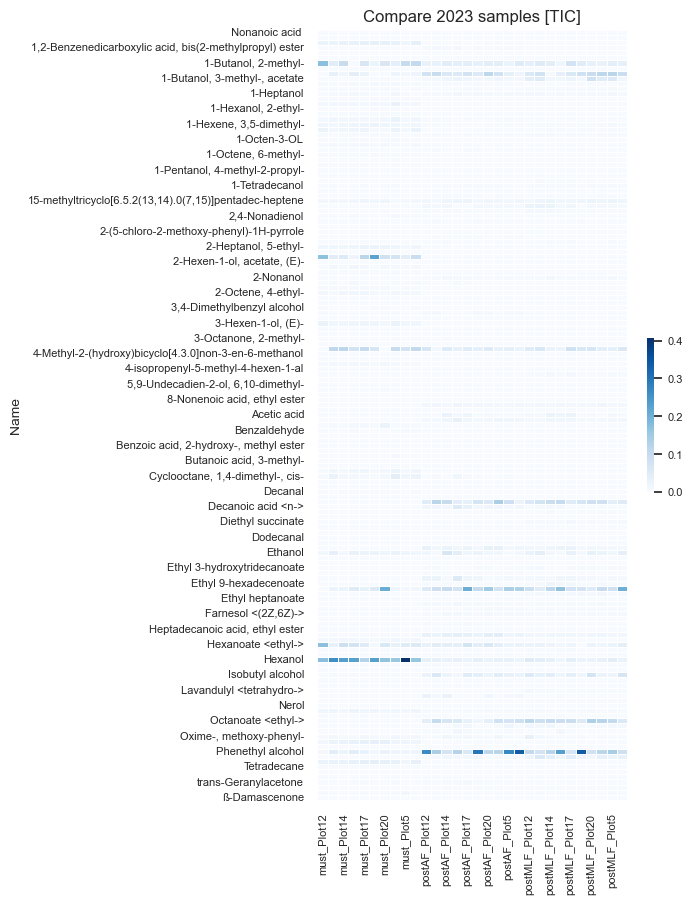

In [31]:
# Create a heatmap using Seaborn with a blue color scheme
plt.figure(figsize=(5, 10))
sns.heatmap(combined_2023_normalized, cmap='Blues', annot=False, cbar=True, cbar_kws={'shrink': 0.2}, linewidths=.5)
plt.title('Compare 2023 samples [TIC]')
plt.show()

<Figure size 1500x800 with 0 Axes>

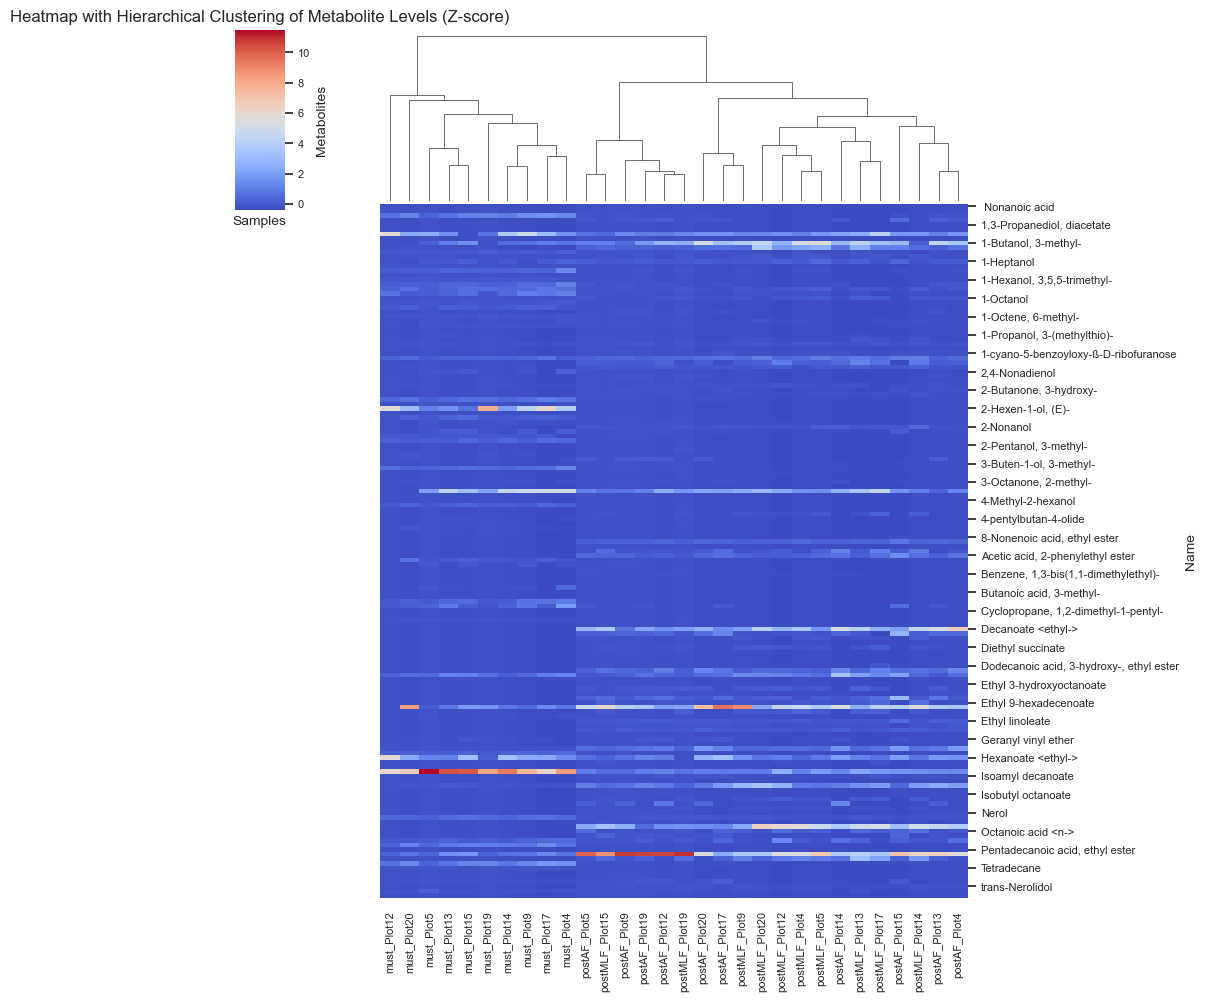

In [33]:
# Calculate z-scores for the DataFrame
z_scores_2023 = (combined_2023_normalized - combined_2023_normalized.mean()) / combined_2023_normalized.std()

# Perform hierarchical clustering on the metabolite levels
linkage = hierarchy.linkage(z_scores_2023.T, method='complete', metric='euclidean')

# Plot the heatmap with hierarchical clustering
plt.figure(figsize=(15, 8))
sns.clustermap(z_scores_2023, method='complete', metric='euclidean', cmap='coolwarm', col_linkage=linkage, row_cluster=False)
plt.title('Heatmap with Hierarchical Clustering of Metabolite Levels (Z-score)')
plt.xlabel('Samples')
plt.ylabel('Metabolites')
plt.show()

#### Heatmap Top variable compounds

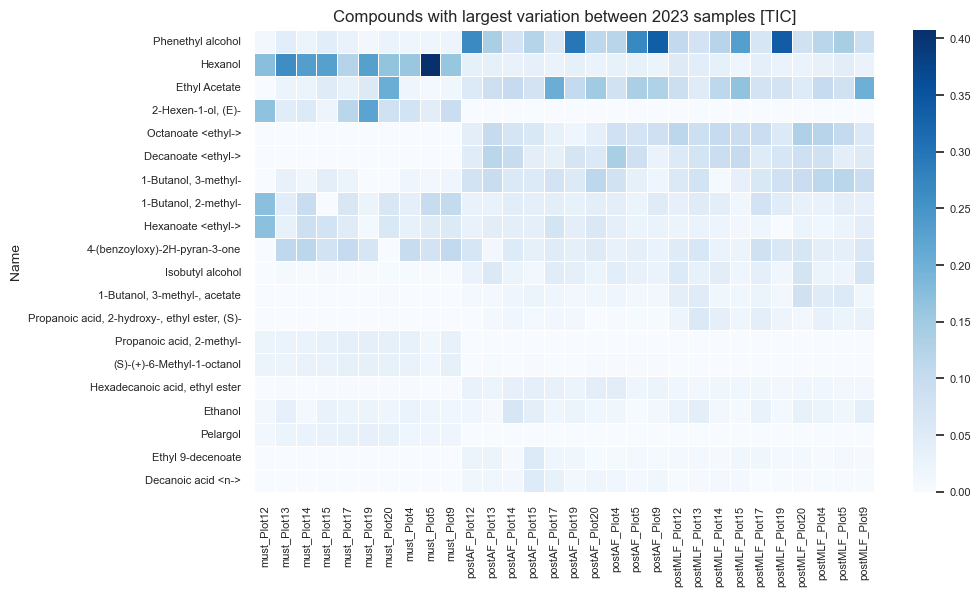

In [32]:
# Calculate row-wise variation and sort by it

combined_df_2023_var = combined_2023_normalized.copy()

# add column for variation along the rows (samples)
combined_df_2023_var['Variation'] = combined_df_2023_var.var(axis=1)
# sort 
combined_df_2023_var_sorted = combined_df_2023_var.sort_values(by='Variation', ascending=False)

# Select the top 10 rows
df_2023_top_var = combined_df_2023_var_sorted.head(20).drop(columns=['Variation'])

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_2023_top_var, annot=False, cmap='Blues', cbar=True, linewidths=.5)
plt.title('Compounds with largest variation between 2023 samples [TIC]')
plt.show()

#### PCA Plot of 2023 samples 

In [59]:
# Instantiate PCA with the number of components you want
n_components = 2  # You can choose the number of principal components
pca = PCA(n_components=n_components)

# drop all rows that contain a NaN because PCA can't handle that 
combined_df_2023_noNA = combined_2023_normalized.dropna()

# transpose!
combined_df_2023_noNA = combined_df_2023_noNA.transpose()

# add a column that indicates the sample type 
combined_df_2023_noNA['Group'] = combined_df_2023_noNA.index.str.split('_').str[0]

# give index a name 
combined_df_2023_noNA.rename_axis(index='Sample', inplace=True)

combined_df_2023_noNA.head()

Name,Nonanoic acid,"(5Z)-Octa-1,5-dien-3-ol",(S)-(+)-6-Methyl-1-octanol,"1,2-Benzenedicarboxylic acid, bis(2-methylpropyl) ester","1,3-Propanediol, diacetate",1-Butanol,"1-Butanol, 2-methyl-","1-Butanol, 3,3-dimethyl-","1-Butanol, 3-methyl-","1-Butanol, 3-methyl-, acetate",...,"Propanoic acid, 2-hydroxy-, ethyl ester, (S)-","Propanoic acid, 2-methyl-",Tetradecane,"Undecanoic acid, ethyl ester",VARAMOL 106 YLBICYCLO[2HYLENE]R]ETHYLPHENYL ESTER]],trans-Geranylacetone,trans-Nerolidol,ß-Citronellol,ß-Damascenone,Group
Sample,,,,,,,,,,,,,,,,,,,,,
must_Plot12,0.0,0.0,0.023094,0.0,0.0,0.0,0.173333,0.0,0.000000,0.0,...,0.0,0.025442,0.002750,0.0,0.0,0.001377,0.0,0.002818,0.0,must
must_Plot13,0.0,0.0,0.023810,0.0,0.0,0.0,0.045006,0.0,0.031253,0.0,...,0.0,0.026071,0.002604,0.0,0.0,0.001301,0.0,0.002239,0.0,must
must_Plot14,0.0,0.0,0.029040,0.0,0.0,0.0,0.096433,0.0,0.017183,0.0,...,0.0,0.027100,0.002702,0.0,0.0,0.001542,0.0,0.001950,0.0,must
must_Plot15,0.0,0.0,0.030131,0.0,0.0,0.0,0.000000,0.0,0.041421,0.0,...,0.0,0.032614,0.002547,0.0,0.0,0.001775,0.0,0.002007,0.0,must
must_Plot17,0.0,0.0,0.035944,0.0,0.0,0.0,0.063050,0.0,0.024654,0.0,...,0.0,0.038510,0.002857,0.0,0.0,0.001909,0.0,0.002141,0.0,must


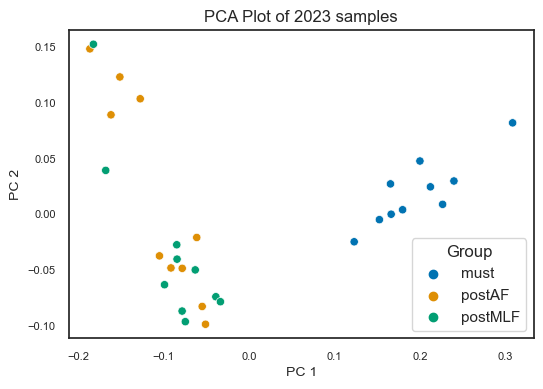

In [60]:
# Fit and transform the data
pca_result = pca.fit_transform(combined_df_2023_noNA.iloc[:, :-1])

# Create a DataFrame with the principal components
pca_columns = [f'PC{i}' for i in range(1, n_components + 1)]
pca_2023 = pd.DataFrame(data=pca_result, columns=pca_columns, index=combined_df_2023_noNA.index)

# add the sample type info back 
pca_2023['Group'] = combined_df_2023_noNA['Group']

# Plot the PCA results with observation labels
plt.figure(figsize=(6, 4))

# make scatterplot and color by sample type 
sns.scatterplot(data=pca_2023, x='PC1', y='PC2', hue='Group', palette='colorblind')

# add the lables 
#for observation, pc1, pc2 in zip(combined_df_2023_noNA.index, pca_2023['PC1'], pca_2023['PC2']): plt.text(pc1, pc2, observation)

plt.title('PCA Plot of 2023 samples')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# Compare all samples 

### PCA 

In [35]:
# Instantiate PCA with the number of components you want
n_components = 2  # You can choose the number of principal components
pca = PCA(n_components=n_components)

# drop all rows that contain a NaN because PCA can't handle that 
combined_df_noNA = all_combined_df_normalized.dropna()
# transpose!
combined_df_noNA = combined_df_noNA.transpose()
# add a column that indicates the sample type and year!
combined_df_noNA['Group'] = combined_df_noNA.index.str.split('_').str[:2].str.join('_')
# give index a name 
combined_df_noNA.rename_axis(index='Sample', inplace=True)


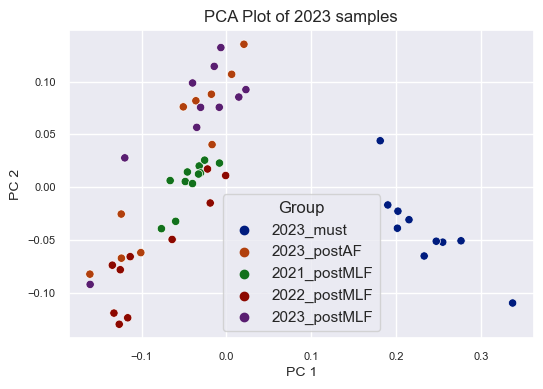

In [36]:
# Fit and transform the data
pca_result = pca.fit_transform(combined_df_noNA.iloc[:, :-1])

# Create a DataFrame with the principal components
pca_columns = [f'PC{i}' for i in range(1, n_components + 1)]
pca_2023 = pd.DataFrame(data=pca_result, columns=pca_columns, index=combined_df_noNA.index)

# add the sample type info back 
pca_2023['Group'] = combined_df_noNA['Group']

# Plot the PCA results with observation labels
plt.figure(figsize=(6, 4))

# make scatterplot and color by sample type 
sns.scatterplot(data=pca_2023, x='PC1', y='PC2', hue='Group', palette='dark')

# add the lables 
#for observation, pc1, pc2 in zip(combined_df_2023_noNA.index, pca_2023['PC1'], pca_2023['PC2']): plt.text(pc1, pc2, observation)

plt.title('PCA Plot of all samples')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

## Diversity analysis (all)

### Shannon Diversity Index

In [65]:
def shannon_diversity(column):
    """Calculate Shannon Diversity for a single column."""
    counts = column.value_counts()  # Count occurrences of each unique value
    total_count = counts.sum()
    probabilities = counts / total_count
    shannon_entropy = -np.sum(probabilities * np.log(probabilities))
    return shannon_entropy

def shannon_diversity_df(df):
    """Calculate Shannon Diversity for each column in a DataFrame."""
    shannon_diversity_values = {}
    for column in df.columns:
        shannon_diversity_values[column] = shannon_diversity(df[column])
    return pd.Series(shannon_diversity_values)

In [66]:
shannon_diversity_results = pd.DataFrame(shannon_diversity_df(all_combined_df_normalized)).reset_index()
shannon_diversity_results.columns = ["Names", "Values"]

In [31]:
# make cols for year and sample type! 
shannon_diversity_results['Sample Type'] = shannon_diversity_results['Names'].apply(lambda x: x.split('_')[1])
shannon_diversity_results['Year'] = shannon_diversity_results['Names'].apply(lambda x: x.split('_')[0])

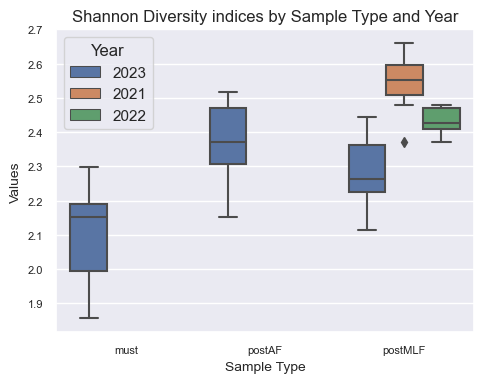

In [32]:
# Plot box plots
plt.figure(figsize=(5, 4))
sns.boxplot(data=shannon_diversity_results, x='Sample Type', y='Values', hue='Year', dodge=True)
plt.title('Shannon Diversity indices by Sample Type and Year')
plt.xlabel('Sample Type')
plt.ylabel('Values')
plt.legend(title='Year')
plt.tight_layout() 
plt.show()

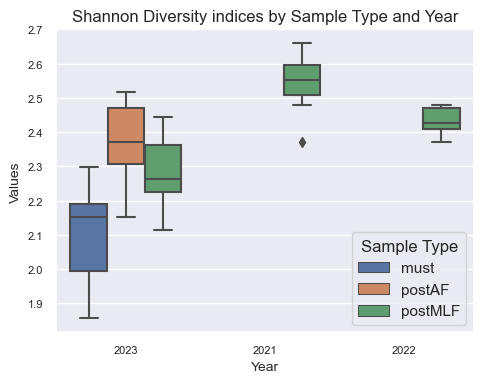

In [33]:
# Plot box plots
plt.figure(figsize=(5, 4))
sns.boxplot(data=shannon_diversity_results, x='Year', y='Values', hue='Sample Type', dodge=True)
plt.title('Shannon Diversity indices by Sample Type and Year')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend(title='Sample Type')
plt.tight_layout() 
plt.show()

### Richness

In [34]:
def richness(df):
    """Calculate richness (number of unique values) for each column in a DataFrame."""
    return df.apply(lambda x: x.nunique())

In [35]:
richness_df = pd.DataFrame(richness(all_combined_df_normalized)).reset_index()
richness_df.columns = ["Names", "Richness"]

# make cols for year and sample type! 
richness_df['Sample Type'] = richness_df['Names'].apply(lambda x: x.split('_')[1])
richness_df['Year'] = richness_df['Names'].apply(lambda x: x.split('_')[0])

#### Check if statistically significant differences

In [36]:
richness_grouped = richness_df.groupby(['Year', 'Sample Type'])['Richness']

# Extract values for each group
group_postMLF_2023_values = richness_grouped.get_group(('2023', 'postMLF'))
group_postMLF_2022_values = richness_grouped.get_group(('2022', 'postMLF'))
group_postMLF_2021_values = richness_grouped.get_group(('2021', 'postMLF'))

# Perform ANOVA tests
print('RICHNESS postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2022_values)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2021_values)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2022_values, group_postMLF_2021_values)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)


print('\n RICHNESS 2023 ANOVAS')
group_must_2023_values = richness_grouped.get_group(('2023', 'must'))
group_postAF_2023_values = richness_grouped.get_group(('2023', 'postAF'))

anova_result = f_oneway(group_must_2023_values, group_postAF_2023_values)
print("ANOVA 2023 must vs postAF p-value:", anova_result.pvalue)
anova_result = f_oneway(group_must_2023_values, group_postMLF_2023_values)
print("ANOVA 2023 must vs postMLF p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postAF_2023_values, group_postMLF_2023_values)
print("ANOVA 2023 postAF vs postMLF p-value:", anova_result.pvalue)

RICHNESS postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.00024669959065453924
ANOVA 2023 vs 2021 p-value: 8.240851861621958e-07
ANOVA 2022 vs 2021 p-value: 0.00046537953231202327

 RICHNESS 2023 ANOVAS
ANOVA 2023 must vs postAF p-value: 0.0003759617148885569
ANOVA 2023 must vs postMLF p-value: 0.006525973640884719
ANOVA 2023 postAF vs postMLF p-value: 0.0917658126785716


#### Box Plots

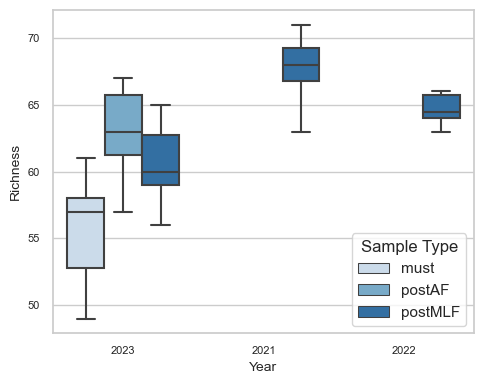

In [37]:
# Plot box plots
sns.set_style(style="whitegrid")
plt.figure(figsize=(5, 4))
sns.boxplot(data=richness_df, x='Year', y='Richness', hue='Sample Type', dodge=True, palette="Blues")
#plt.title('Richness by Sample Type and Year')
plt.xlabel('Year')
plt.ylabel('Richness')
plt.legend(title='Sample Type')
plt.tight_layout()
plt.savefig('Figures/Richness-BoxPlot.png', bbox_inches='tight', dpi=1000)
plt.show()

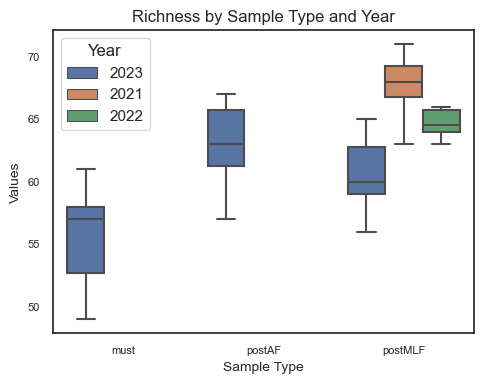

In [38]:
# Plot box plots
sns.set_style(style="white")
plt.figure(figsize=(5, 4))
sns.boxplot(data=richness_df, x='Sample Type', y='Richness', hue='Year', dodge=True)
plt.title('Richness by Sample Type and Year')
plt.xlabel('Sample Type')
plt.ylabel('Values')
plt.legend(title='Year')
plt.tight_layout() 
plt.show()

# Environmental Factors shaping the VOCs

## Compare MLF samples of different years
Let's first compare the postMLF samples from different years and whether there is any correspondence with the plot features. 

combined_MLF_normalized
plots_md